## Dataset Analysis
### 09/09/25

In [14]:
#### Load libs
from ase.db import connect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import annotations
import os, json, sqlite3, re, math
from functools import reduce
from pymatgen.core import Structure
from pymatgen.analysis.structure_matcher import StructureMatcher
from scipy.stats import pearsonr
from tqdm import tqdm

# Set paths to databases
C2DB_PATH = "c2db.db"
MP2D_PATH = "2dmatpedia_final.db"
DB_PATHS = ["c2db.db", "2dmatpedia_final.db"]

## Distribution Analysis for C2DB 

In [3]:
# Path to the database file
db = connect(C2DB_PATH)

records = []
all_kv_keys, all_data_keys = set(), set()

# Connecting to the SQLite database
conn = sqlite3.connect(C2DB_PATH)

# Listing available tables
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("Available tables in the database:\n", tables)

Available tables in the database:
                 name
0            systems
1    sqlite_sequence
2            species
3               keys
4    text_key_values
5  number_key_values
6        information


In [4]:
for row in db.select():
    # Basic fields guaranteed by ASE
    base = {
        "id": row.id,
        "formula": getattr(row, "formula", None),
        "natoms": getattr(row, "natoms", None),
        "calculator": getattr(row, "calculator", None),
        "pbc": getattr(row, "pbc", None),
        "user": getattr(row, "user", None),
        "mtime": getattr(row, "mtime", None),
        "ctime": getattr(row, "ctime", None),
        "key_value_pairs": None,   # just for reference
        "data_keys": None          # just for reference
    }
    # Key-value pairs and data (may contain many properties)
    kv = dict(getattr(row, "key_value_pairs", {}) or {})
    data = dict(getattr(row, "data", {}) or {})

    all_kv_keys |= set(kv.keys())
    all_data_keys |= set(data.keys())

    # Simple filter: keep only convertible scalars (avoids nested lists/arrays)
    def keep_scalar(x):
        return (
            x is None or
            isinstance(x, (str, int, float, bool, np.number))
        )

    kv_flat = {k: v for k, v in kv.items() if keep_scalar(v)}
    data_flat = {k: v for k, v in data.items() if keep_scalar(v)}

    rec = {**base, **kv_flat, **data_flat}
    rec["key_value_pairs"] = list(kv_flat.keys())
    rec["data_keys"] = list(data_flat.keys())
    records.append(rec)

df = pd.DataFrame.from_records(records)

print(f"Records read: {len(df)}")
print(f"Total columns in DataFrame: {len(df.columns)}")

Records read: 16905
Total columns in DataFrame: 93


In [5]:
# --- STEP 2 (robust version) ---
inf_tokens = {
    "Inf": np.inf, "-Inf": -np.inf, "inf": np.inf, "-inf": -np.inf,
    "+Inf": np.inf, "+inf": np.inf, "INf": np.inf, "InF": np.inf
}

def is_scalar_like(x):
    return (
        x is None or
        isinstance(x, (str, int, float, bool, np.number, np.bool_))
    )

def norm_inf_token(v):
    if isinstance(v, str):
        return inf_tokens.get(v.strip(), v)
    return v

cols_arraylike = []

for col in df.columns:
    s = df[col]
    # if the column has any non-scalar value (list/array/dict), skip it
    nn = s.dropna()
    if not nn.empty and nn.map(lambda x: not is_scalar_like(x)).any():
        cols_arraylike.append(col)
        continue

    if s.dtype == object:
        # normalize infinity tokens per element
        s = s.map(norm_inf_token)
        # try to convert to numeric when it makes sense
        coerced = pd.to_numeric(s, errors="coerce")
        if coerced.notna().mean() >= 0.2:   # heuristic
            df[col] = coerced
        else:
            df[col] = s

print("Columns ignored for containing list/array/dict:", cols_arraylike)

Columns ignored for containing list/array/dict: ['pbc', 'key_value_pairs', 'data_keys']


In [6]:
# === 3) Top 25 columns with the fewest nulls (most complete) ===
null_counts = df.isna().sum().sort_values()
print("\nTop 15 properties with the fewest nulls:")
top15_notnull = null_counts.head(25)
print(top15_notnull)


Top 15 properties with the fewest nulls:
id                          0
formula                     0
natoms                      0
calculator                  0
pbc                         0
user                        0
mtime                       0
ctime                       0
key_value_pairs             0
data_keys                   0
folder                      0
uid                         0
international               0
number                      0
has_inversion_symmetry      0
lgnum                       0
thickness                   0
layergroup                  0
hform                       0
dyn_stab                    0
ehull                       0
olduid                    116
label                     139
bravais_search            210
bravais_type              210
dtype: int64


In [7]:
# === 3) Top 25 columns with the fewest nulls (most complete) ===
null_counts = df.isna().sum().sort_values()
not_zero = null_counts[null_counts > 0]
print("\nTop 25 properties with the fewest nulls:")
top25_notnull = not_zero.head(25)
print(top25_notnull)


Top 25 properties with the fewest nulls:
olduid                 116
label                  139
bravais_search         210
bravais_type           210
is_magnetic           8204
dE_zy                 8204
spin_axis             8204
dE_zx                 8204
efermi                8206
gap_dir_nosoc         8206
evac                  8206
evacdiff              8206
gap_dir               8206
gap                   8206
dipz                  8206
minhessianeig         8756
alphaz_el            11553
alphax_el            11553
alphay_el            11553
cbm                  12338
vbm                  12338
plasmafrequency_x    12974
plasmafrequency_y    12974
emass_cbm            13241
emass_vbm            13241
dtype: int64


## Distribution Analysis for 2DMatPedia 


In [7]:
# =========================
# Utilities
# =========================
def is_scalar_like(x):
    return (
        x is None or
        isinstance(x, (str, int, float, bool, np.number, np.bool_))
    )

inf_tokens = {
    "Inf": np.inf, "-Inf": -np.inf, "inf": np.inf, "-inf": -np.inf,
    "+Inf": np.inf, "+inf": np.inf, "INf": np.inf, "InF": np.inf,
    "NaN": np.nan, "nan": np.nan
}
def norm_inf_token(v):
    if isinstance(v, str):
        return inf_tokens.get(v.strip(), v)
    return v

def normalize_df_inplace(df: pd.DataFrame):
    """Converts object columns to numeric when appropriate
    and handles 'Inf', '-Inf', etc. Without exploding columns with arrays/lists."""
    cols_arraylike = []
    for col in df.columns:
        s = df[col]
        nn = s.dropna()
        if not nn.empty and nn.map(lambda x: not is_scalar_like(x)).any():
            cols_arraylike.append(col)
            continue
        if s.dtype == object:
            s = s.map(norm_inf_token)
            coerced = pd.to_numeric(s, errors="coerce")
            if coerced.notna().mean() >= 0.2:
                df[col] = coerced
            else:
                df[col] = s
    return cols_arraylike

def first_existing(cols, candidates):
    for c in candidates:
        if c in cols:
            return c
    return None

In [8]:
# =========================
# Loader 1: ASE .db
# =========================
def load_as_ase_db(path: str) -> pd.DataFrame:
    db = connect(path)
    records = []
    for row in db.select():
        base = {
            "id": getattr(row, "id", None),
            "formula": getattr(row, "formula", None),
            "natoms": getattr(row, "natoms", None),
            "calculator": getattr(row, "calculator", None),
            "pbc": getattr(row, "pbc", None),
            "mtime": getattr(row, "mtime", None),
            "ctime": getattr(row, "ctime", None),
        }
        kv = dict(getattr(row, "key_value_pairs", {}) or {})
        data = dict(getattr(row, "data", {}) or {})

        # keep only scalars (avoids arrays/cells)
        kv_flat = {k: v for k, v in kv.items() if is_scalar_like(v)}
        data_flat = {k: v for k, v in data.items() if is_scalar_like(v)}

        rec = {**base, **kv_flat, **data_flat}
        records.append(rec)
    return pd.DataFrame.from_records(records)

In [9]:
# =========================
# Loader 2: SQLite .db
# =========================
def load_as_sqlite_db(path: str) -> pd.DataFrame:
    con = sqlite3.connect(path)
    try:
        tables = pd.read_sql_query(
            "SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%';",
            con
        )["name"].tolist()
        if not tables:
            raise RuntimeError("No tables found in SQLite.")

        # Read all tables
        dfs = {}
        sizes = {}
        for t in tables:
            df_t = pd.read_sql_query(f"SELECT * FROM '{t}';", con)
            dfs[t] = df_t
            sizes[t] = len(df_t)

        # Try to find a common key to join (preference order)
        candidate_keys = ["material_id", "id", "entry_id", "mp_id", "uid", "structure_id"]
        common_key = None
        for key in candidate_keys:
            # present in at least two tables?
            if sum(int(key in df.columns) for df in dfs.values()) >= 2:
                common_key = key
                break

        if common_key:
            # join all tables that have the key
            to_merge = [df for df in dfs.values() if common_key in df.columns]
            df = reduce(lambda l, r: pd.merge(l, r, on=common_key, how="outer"), to_merge)
        else:
            # no common key: take the largest table as base
            main_table = max(sizes, key=sizes.get)
            df = dfs[main_table]

        return df
    finally:
        con.close()

In [10]:
# =========================
# Orchestration: tries ASE -> falls back to SQLite
# =========================
def load_2dmatpedia_db(path: str) -> pd.DataFrame:
    # Simple heuristic: if you can import ASE and open, use it; otherwise, SQLite
    try:
        from ase.db import connect  # noqa: F401
        # quick attempt to open as ASE
        df = load_as_ase_db(path)
        if not df.empty:
            print("[INFO] Loaded as ASE .db")
            return df
        # if empty, try SQLite
        print("[WARN] ASE returned empty; trying as SQLite…")
        return load_as_sqlite_db(path)
    except Exception as e:
        print(f"[WARN] Failed as ASE ({e}); trying as SQLite…")
        return load_as_sqlite_db(path)

[INFO] Loaded as ASE .db
Records read: 6351 | Columns: 32
Columns ignored for containing list/array/dict: ['pbc']

Top 15 properties with the fewest nulls (numeric only):
id                                0
natoms                            0
mtime                             0
ctime                             0
nelements                         0
sg_number                         0
bandgap                           0
total_magnetization               0
energy_vdw_per_atom               0
energy_per_atom                 195
decomposition_energy            196
exfoliation_energy_per_atom    1824
dtype: int64


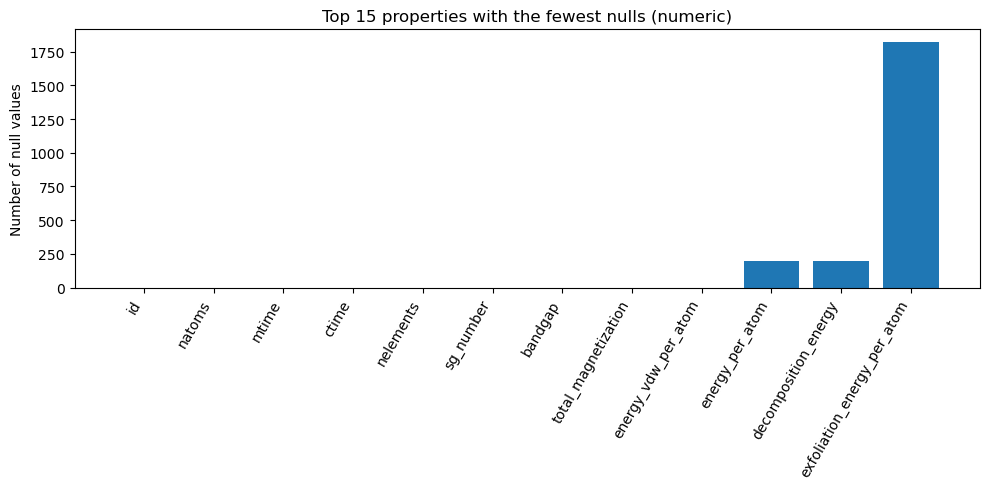

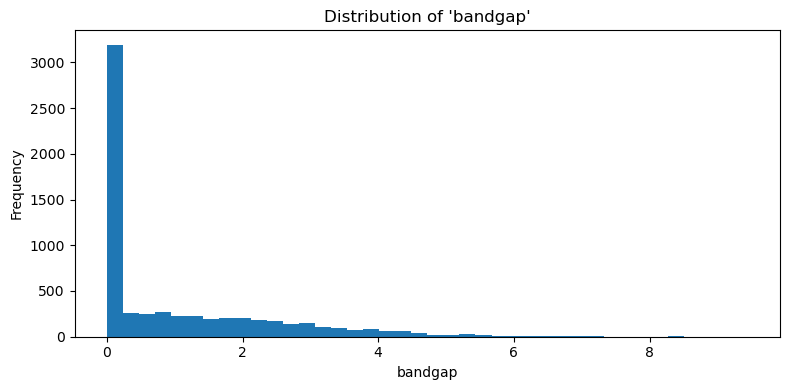

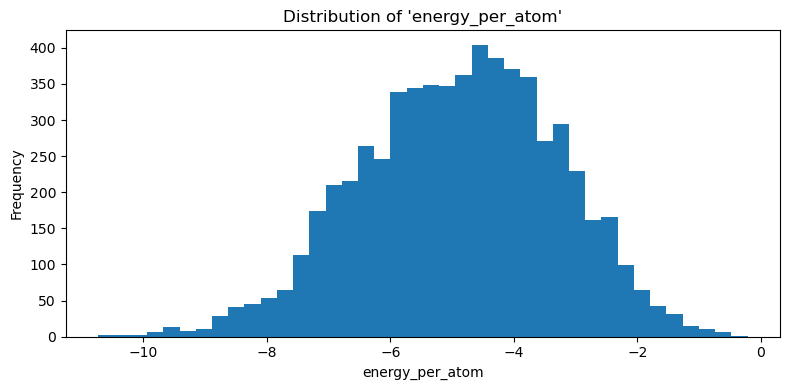

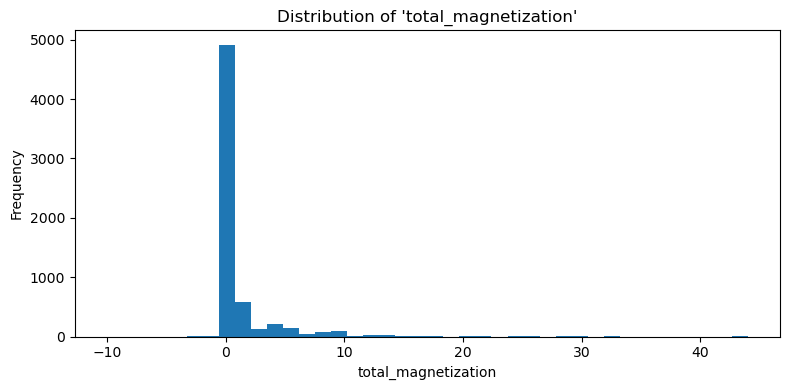

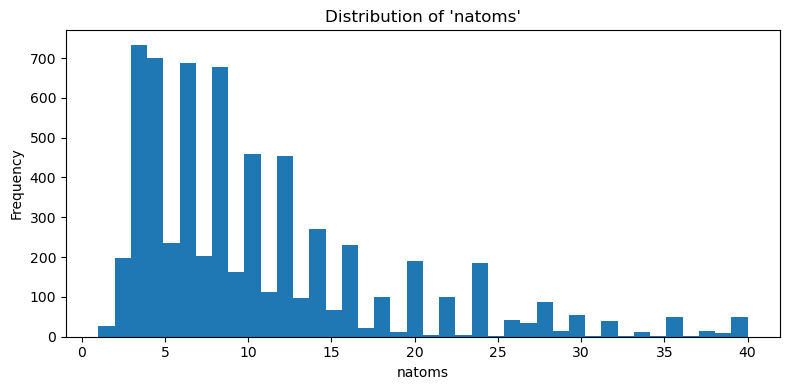


Sample of columns: ['id', 'formula', 'natoms', 'calculator', 'pbc', 'mtime', 'ctime', 'material_id', 'relative_id', 'source_id', 'creation_task_label', 'discovery_process', 'formula_pretty', 'formula_reduced_abc', 'formula_anonymous', 'chemsys', 'nelements', 'sg_number', 'sg_symbol', 'bandgap', 'total_magnetization', 'energy_per_atom', 'energy_vdw_per_atom', 'exfoliation_energy_per_atom', 'decomposition_energy', 'sg_crystal_system', 'sg_point_group', 'sg_hall', 'elements', 'created_at']


In [11]:
# =========================
# Execution
# =========================
if __name__ == "__main__":
    assert os.path.exists(MP2D_PATH), f"File not found: {MP2D_PATH}"
    df = load_2dmatpedia_db(MP2D_PATH)
    print(f"Records read: {len(df)} | Columns: {len(df.columns)}")

    # Normalization
    cols_arraylike = normalize_df_inplace(df)
    if cols_arraylike:
        print("Columns ignored for containing list/array/dict:", cols_arraylike)

    # Focus on numeric columns for metrics/histograms
    df_num = df.select_dtypes(include=[np.number])
    if df_num.empty:
        print("No numeric columns available after normalization.")
    else:
        # Top N columns with the fewest nulls
        N = 15
        null_counts = df_num.isna().sum().sort_values()
        top_notnull = null_counts.head(N)
        print(f"\nTop {N} properties with the fewest nulls (numeric only):")
        print(top_notnull)

        plt.figure(figsize=(10, 5))
        plt.bar(top_notnull.index.astype(str), top_notnull.values)
        plt.xticks(rotation=60, ha="right")
        plt.ylabel("Number of null values")
        plt.title(f"Top {N} properties with the fewest nulls (numeric)")
        plt.tight_layout()
        plt.show()

    # Histograms of key properties (with 2DMatPedia/C2DB synonyms)
    prop_synonyms = {
        "band_gap": [
            "band_gap", "bandgap", "gap", "Eg", "Egap", "E_g",
            "bandgap_pbe", "bandgap_lda"
        ],
        "energy": [
            "energy", "total_energy", "potential_energy",
            "energy_per_atom", "formation_energy_per_atom",
            "formation_energy", "e_form", "e_form_per_atom",
            "delta_e", "stability"
        ],
        "magmom": [
            "magmom", "tot_magmom", "magnetic_moment",
            "total_magnetization", "magnetization", "magmom_per_cell"
        ],
        "natoms": [
            "natoms", "n_atoms", "num_atoms", "N"
        ]
    }

    for label, candidates in prop_synonyms.items():
        col = first_existing(df.columns, candidates)
        if col is None:
            print(f"Did not find any column among {candidates}")
            continue

        s = df[col]
        if s.dtype == object:
            s = pd.to_numeric(s.map(norm_inf_token), errors="coerce")
        else:
            s = s.astype(float)

        s = s.dropna()
        if s.empty:
            print(f"Column '{col}' found, but no numeric data to plot.")
            continue

        plt.figure(figsize=(8, 4))
        plt.hist(s, bins=40)
        plt.title(f"Distribution of '{col}'")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

    # Tip: list some columns
    print("\nSample of columns:", list(df.columns)[:30])

## Comparison between C2DB and 2DMatPedia

### Verify the number of commum systems (by formula+symmetry)

In [11]:
# --- File Configuration ---
OUTPUT_CSV = "common_formula_symmetry.csv"

def get_prototypes_from_db(db_path: str) -> set:
    """
    Reads an ASE database and extracts a unique set of prototypes
    (formula, symmetry_type, symmetry_value).
    """
    if not os.path.exists(db_path):
        print(f"WARNING: Database file not found: {db_path}")
        return set()

    prototypes = set()
    db = connect(db_path)
    
    # --- Identify symmetry columns (once) ---
    try:
        row = next(db.select(limit=1))
        keys = list(row.key_value_pairs.keys()) + list(getattr(row, 'data', {}).keys())
    except StopIteration:
        return set() # Empty database

    num_col_candidates = ["sg_number", "spacegroup_number", "number", "lgnum", "layergroup_number"]
    sym_col_candidates = ["sg_symbol", "spacegroup_symbol", "international", "layergroup"]
    
    num_col = next((c for c in num_col_candidates if c in keys), None)
    sym_col = next((c for c in sym_col_candidates if c in keys), None)

    # --- Iterate over all database entries ---
    for row in db.select():
        formula = row.get("formula_norm", row.formula)
        
        # Priority 1: Use symmetry number if available and valid
        if num_col and row.get(num_col) is not None:
            try:
                sym_num = int(row.get(num_col))
                prototypes.add((formula, "number", str(sym_num)))
            except (ValueError, TypeError):
                continue # Ignore if not a valid number

        # Priority 2: Use symmetry symbol if no number
        elif sym_col and row.get(sym_col) is not None:
            try:
                # Normalize symbol for consistent comparison
                sym_symb = re.sub(r"\s+", "", str(row.get(sym_col)).strip()).replace('"', '').replace("'", "")
                if sym_symb:
                    prototypes.add((formula, "symbol", sym_symb))
            except (ValueError, TypeError):
                continue
            
    print(f"Found {len(prototypes)} unique prototypes in '{db_path}'.\n")
    return prototypes

def main():
    """
    Main function to run the comparison and save the analysis.
    """
    if len(DB_PATHS) < 2:
        print("Error: At least two databases are required in DB_PATHS for comparison.")
        return

    # 1. Extract prototypes from each database
    all_prototypes = {db_path: get_prototypes_from_db(db_path) for db_path in DB_PATHS}

    # 2. Find the union of all prototypes from all databases
    # This gives us a complete list of all systems without duplicates
    union_prototypes = set.union(*all_prototypes.values())
    
    # 3. Prepare the data for analysis in a DataFrame
    analysis_data = []
    for proto in sorted(list(union_prototypes)): # Sort for a consistent output
        formula, sym_type, sym_value = proto
        
        row_data = {
            "formula": formula,
            "symmetry_type": sym_type,
            "symmetry_value": sym_value
        }
        
        # Add a column for each database, marking presence (True/False)
        for db_path, proto_set in all_prototypes.items():
            # Use the filename as the column name
            col_name = f"in_{os.path.basename(db_path).replace('.db', '')}"
            row_data[col_name] = proto in proto_set
            
        analysis_data.append(row_data)

    if not analysis_data:
        print("No prototypes were found in any database. No output file will be generated.")
        return
        
    # 4. Create the DataFrame and calculate the count of common systems
    df_analysis = pd.DataFrame(analysis_data)
    
    # Presence columns (e.g., 'in_c2db', 'in_2dmatpedia_final')
    presence_columns = [col for col in df_analysis.columns if col.startswith('in_')]
    
    # A system is "common" if it is present in ALL presence columns
    common_systems_mask = df_analysis[presence_columns].all(axis=1)
    num_common_systems = common_systems_mask.sum()

    # 5. Save the DataFrame to the CSV file
    df_analysis.to_csv(OUTPUT_CSV, index=False)
    
    print("================== Analysis Summary ==================")
    for db_path, proto_set in all_prototypes.items():
        print(f"Total unique prototypes in '{os.path.basename(db_path)}': {len(proto_set)}")
    print("-" * 55)
    print(f"Total unique prototypes (combined): {len(union_prototypes)}")
    print(f"Number of prototypes common to ALL databases: {num_common_systems}")
    print("======================================================")
    print(f"\nComplete analysis successfully saved to: '{OUTPUT_CSV}'")

if __name__ == "__main__":
    main()

Found 16504 unique prototypes in 'c2db.db'.

Found 6159 unique prototypes in '2dmatpedia_final.db'.

================== Analysis Summary ==================
Total unique prototypes in 'c2db.db': 16504
Total unique prototypes in '2dmatpedia_final.db': 6159
-------------------------------------------------------
Total unique prototypes (combined): 21443
Number of prototypes common to ALL databases: 1220

Complete analysis successfully saved to: 'common_formula_symmetry.csv'


### Verify duplicates (by formula+symmetry)

In [23]:
def find_duplicate_prototypes(db_path: str):
    """
    Analyzes an ASE database, counts the occurrence of each prototype
    (formula + symmetry), and reports those that appear more than once.
    """
    print(f"--- Checking duplicates in '{db_path}' ---")
    
    if not os.path.exists(db_path):
        print(f"WARNING: File not found: {db_path}\n")
        return

    all_prototypes = []
    db = connect(db_path)
    
    # --- Identify symmetry columns (once) ---
    try:
        row = next(db.select(limit=1))
        keys = list(row.key_value_pairs.keys()) + list(getattr(row, 'data', {}).keys())
    except StopIteration:
        print("Database is empty.\n")
        return

    num_col_candidates = ["sg_number", "spacegroup_number", "number", "lgnum", "layergroup_number"]
    sym_col_candidates = ["sg_symbol", "spacegroup_symbol", "international", "layergroup"]
    
    num_col = next((c for c in num_col_candidates if c in keys), None)
    sym_col = next((c for c in sym_col_candidates if c in keys), None)

    # --- Iterate and collect ALL prototypes, without removing duplicates ---
    for row in db.select():
        formula = row.get("formula_norm", row.formula)
        prototype = None
        
        if num_col and row.get(num_col) is not None:
            try:
                sym_num = int(row.get(num_col))
                prototype = (formula, "number", str(sym_num))
            except (ValueError, TypeError):
                pass
        
        elif sym_col and row.get(sym_col) is not None:
            try:
                sym_symb = re.sub(r"\s+", "", str(row.get(sym_col)).strip()).replace('"', '').replace("'", "")
                if sym_symb:
                    prototype = (formula, "symbol", sym_symb)
            except (ValueError, TypeError):
                pass
        
        if prototype:
            all_prototypes.append(prototype)
    
    if not all_prototypes:
        print("No valid prototype found.\n")
        return

    # --- Use pandas to count occurrences and find duplicates ---
    proto_series = pd.Series(all_prototypes)
    counts = proto_series.value_counts()
    duplicates = counts[counts > 1]

    total_entries = len(db)
    unique_prototypes = len(counts)
    
    print(f"Total entries in the database: {total_entries}")
    print(f"Number of unique prototypes: {unique_prototypes}")
    
    if duplicates.empty:
        print("=> No duplicate prototype (formula + symmetry) found.")
    else:
        print(f"=> Found {len(duplicates)} prototypes that repeat.")
        print("   Sample of repeated prototypes (Formula, Symmetry Type, Symmetry Value): Count")
        # Convert to a more readable format before printing
        for (formula, sym_type, sym_val), count in duplicates.head(10).items():
            print(f"   - ({formula}, {sym_type}, {sym_val}): {count} times")
        
        if len(duplicates) > 10:
            print(f"   ... and {len(duplicates) - 10} more.")

    print("\n" + "="*50 + "\n")


# --- Main Logic ---
if __name__ == "__main__":
    for path in DB_PATHS:
        find_duplicate_prototypes(path)

--- Checking duplicates in 'c2db.db' ---
Total entries in the database: 16905
Number of unique prototypes: 16504
=> Found 387 prototypes that repeat.
   Sample of repeated prototypes (Formula, Symmetry Type, Symmetry Value): Count
   - (Ir2S2, number, 164): 4 times
   - (W2Te2, number, 164): 3 times
   - (W2S2, number, 164): 3 times
   - (Ir2Te2, number, 164): 3 times
   - (Os2Cl2, number, 164): 3 times
   - (Na2I2, number, 129): 3 times
   - (Au2Se2, number, 164): 3 times
   - (Zr2Cl2, number, 164): 3 times
   - (Bi2S2, number, 164): 3 times
   - (Ti2S2, number, 164): 3 times
   ... and 377 more.


--- Checking duplicates in '2dmatpedia_final.db' ---
Total entries in the database: 6351
Number of unique prototypes: 6159
=> Found 183 prototypes that repeat.
   Sample of repeated prototypes (Formula, Symmetry Type, Symmetry Value): Count
   - (In2ZnS4, number, 156): 3 times
   - (Cu8W4O16, number, 2): 3 times
   - (Al2ZnS4, number, 156): 3 times
   - (Ta4Se6, number, 11): 3 times
   - (K

### Verify geometry completeness

In [24]:
def check_database_geometries(db_path):
    """
    Checks an ASE database to count how many entries
    have valid geometry data.
    """
    if not os.path.exists(db_path):
        print(f"File not found: {db_path}\n")
        return

    print(f"Analyzing {db_path}...")
    
    db = connect(db_path)
    total_entries = 0
    with_geometry = 0

    for row in db.select():
        total_entries += 1
        
        try:
            # The most reliable way to check geometry is to try
            # to reconstruct the Atoms object.
            atoms = row.toatoms()
            
            # Check if the cell (lattice parameters) is not null or empty.
            # atoms.cell.any() checks if there is any non-zero value in the cell matrix.
            if atoms and hasattr(atoms, 'cell') and np.any(atoms.cell):
                with_geometry += 1
        except Exception:
            # If reconstruction fails, consider there is no geometry data.
            continue
            
    # Print the results for this database
    if total_entries > 0:
        percentage = (with_geometry / total_entries) * 100
        print(f"- Total entries: {total_entries}")
        print(f"- Entries with geometry data: {with_geometry} ({percentage:.2f}%)")
    else:
        print("- No entries found in the database.")
    
    print("-" * 20)

if __name__ == "__main__":
    for path in DB_PATHS:
        check_database_geometries(path)

Analyzing c2db.db...
- Total entries: 16905
- Entries with geometry data: 16905 (100.00%)
--------------------
Analyzing 2dmatpedia_final.db...
- Total entries: 6351
- Entries with geometry data: 6351 (100.00%)
--------------------


### Verify geometry differences in commum structures

In [10]:
# Detailed structural comparison between the datasets (CORRECTED VERSION)

# This file should be the result of the symmetry analysis from your notebook
COMMON_PROTOS_CSV = "common_formula_symmetry.csv"

# --- Helper Functions (unchanged) ---
def get_db_keys(db_path):
    """Gets a sample of database keys to avoid reopening."""
    conn = connect(db_path)
    try:
        row = next(conn.select(limit=1))
        return list(row.key_value_pairs.keys()) + list(getattr(row, 'data', {}).keys())
    except StopIteration:
        return []

def pick_sym_num_col(keys):
    for c in ["sg_number", "spacegroup_number", "number", "lgnum", "layergroup_number"]:
        if c in keys:
            return c
    return None

def pick_sym_symb_col(keys):
    for c in ["sg_symbol", "spacegroup_symbol", "international", "layergroup", "sg_hall", "hall_symbol"]:
        if c in keys:
            return c
    return None

def norm_symb(x):
    if not isinstance(x, str): return None
    s = re.sub(r"\s+", "", x.strip()).replace('"', '').replace("'", "")
    return s

# --- Main Function for Structure Extraction (CORRECTED VERSION) ---
def get_structure_from_ase(db_path, formula, sym_type, sym_val, sym_num_col, sym_symb_col):
    """
    Searches the ASE database for a structure matching the formula and symmetry.
    This version is more robust, iterating over results to ensure a match.
    """
    db = connect(db_path)
    
    # The primary query should be by 'formula_norm', which is the key you created.
    candidates = list(db.select(f'formula_norm="{formula}"'))

    # If the search by 'formula_norm' returns nothing, try the default 'formula' key.
    if not candidates:
        candidates = list(db.select(formula=formula))

    # Now, iterate over candidates to find the correct symmetry.
    for row in candidates:
        try:
            if sym_type == 'number':
                # Compare the symmetry group number.
                db_sym_num = row.get(sym_num_col)
                if db_sym_num is not None and int(db_sym_num) == int(sym_val):
                    return row.toatoms()
            
            elif sym_type == 'symbol':
                # Compare the symmetry group symbol after normalization.
                db_sym_symb = row.get(sym_symb_col)
                if db_sym_symb is not None and norm_symb(db_sym_symb) == sym_val:
                    return row.toatoms()
        except (ValueError, TypeError):
            # Ignore the row if there is a conversion error (e.g., sym_val is not a number)
            continue
            
    # If the loop ends without finding a symmetry match, return None.
    # This is the correct behavior, instead of a fallback that ignores symmetry.
    return None


# --- Comparison Logic (unchanged) ---
if __name__ == "__main__":
    if not os.path.exists(COMMON_PROTOS_CSV):
        print(f"File '{COMMON_PROTOS_CSV}' not found.")
        print("Please run the notebook cell that generates this file first.")
    else:
        common_protos_df = pd.read_csv(COMMON_PROTOS_CSV)

        # Get the keys once for optimization
        c2_keys = get_db_keys(C2DB_PATH)
        m2_keys = get_db_keys(MP2D_PATH)

        sym_num_c2 = pick_sym_num_col(c2_keys)
        sym_symb_c2 = pick_sym_symb_col(c2_keys)
        sym_num_m2 = pick_sym_num_col(m2_keys)
        sym_symb_m2 = pick_sym_symb_col(m2_keys)

        matcher = StructureMatcher(ltol=0.2, stol=0.3, angle_tol=5)
        comparison_results = []

        print(f"Starting comparison for {len(common_protos_df)} common prototypes...")

        for index, row in common_protos_df.iterrows():
            formula = row['formula']
            sym_type = row['symmetry_type']
            sym_val = str(row['symmetry_value'])

            atoms_c2 = get_structure_from_ase(C2DB_PATH, formula, sym_type, sym_val, sym_num_c2, sym_symb_c2)
            atoms_m2 = get_structure_from_ase(MP2D_PATH, formula, sym_type, sym_val, sym_num_m2, sym_symb_m2)

            result = {
                'formula': formula,
                'sym_type': sym_type,
                'sym_val': sym_val,
                'found_c2db': atoms_c2 is not None,
                'found_2dmatpedia': atoms_m2 is not None,
                'geometries_match': None,
                'rms_displacement': None,
                'lattice_c2db': None,
                'lattice_2dmatpedia': None
            }

            if atoms_c2 and atoms_m2:
                struct_c2 = Structure(lattice=atoms_c2.cell, species=atoms_c2.get_chemical_symbols(), coords=atoms_c2.get_scaled_positions())
                struct_m2 = Structure(lattice=atoms_m2.cell, species=atoms_m2.get_chemical_symbols(), coords=atoms_m2.get_scaled_positions())

                match = matcher.fit(struct_c2, struct_m2)
                result['geometries_match'] = match
                
                if match:
                    rms_dist, _ = matcher.get_rms_dist(struct_c2, struct_m2)
                    result['rms_displacement'] = rms_dist
                
                lp_c2 = struct_c2.lattice.parameters
                lp_m2 = struct_m2.lattice.parameters
                result['lattice_c2db'] = f"a={lp_c2[0]:.3f}, b={lp_c2[1]:.3f}, c={lp_c2[2]:.3f}"
                result['lattice_2dmatpedia'] = f"a={lp_m2[0]:.3f}, b={lp_m2[1]:.3f}, c={lp_m2[2]:.3f}"

            comparison_results.append(result)

        results_df = pd.DataFrame(comparison_results)
        output_filename = "geometry_comparison_results.csv"
        results_df.to_csv(output_filename, index=False)

        print("\n--- Geometry Comparison Summary ---")
        total_checked = len(results_df)
        found_in_both = results_df[results_df['found_c2db'] & results_df['found_2dmatpedia']].shape[0]
        matches = results_df['geometries_match'].sum()
        mismatches = found_in_both - (matches if not np.isnan(matches) else 0)

        print(f"Total common prototypes analyzed: {total_checked}")
        print(f"Found in both databases: {found_in_both}")
        print(f"  - Compatible geometries: {int(matches) if not np.isnan(matches) else 0}")
        print(f"  - Non-compatible geometries: {int(mismatches)}")
        
        print(f"\nDetailed results saved in: '{output_filename}'")

        # Shows cases that were not found, which should now be 0
        not_found_df = results_df[~(results_df['found_c2db'] & results_df['found_2dmatpedia'])]
        if not not_found_df.empty:
            print("\nWARNING: Prototypes that should exist but were not found:")
            print(not_found_df[['formula', 'sym_val']].head())

File 'common_formula_symmetry.csv' not found.
Please run the notebook cell that generates this file first.


### Verify properties correlation in commum structures

Starting property comparison for 21443 common prototypes...


  0%|          | 0/21443 [00:00<?, ?it/s]

100%|██████████| 21443/21443 [01:31<00:00, 234.95it/s]



Comparison results saved to 'properties_comparison.csv'.

Sample of the compared data:
     formula  sym_val  ehull_c2db  decomp_energy_m2  gap_c2db  gap_m2  \
0  Ag2Au2Cl8       13    0.000000          0.000000  0.908975  0.8121   
1     Ag2Ba2      191    0.152343          0.181022       NaN  0.0000   
2     Ag2Br2      164    0.009142          0.037847  1.723804  1.8664   
3     Ag2Br2       67    0.010123          0.070731  2.443795  2.5154   
4     Ag2Br4       14    0.000588          0.036838  0.000000  0.0000   

   magmom_u_c2db  total_magnetization_m2  energy_c2db  energy_per_atom_m2  \
0            NaN                0.000000   -30.882453           -2.603228   
1            NaN               -0.000295    -9.962851           -2.479748   
2            NaN               -0.000000   -10.201959           -2.564083   
3            NaN               -0.000000   -10.198035           -2.531200   
4            NaN                1.857922   -13.465184           -2.240787   

   natoms_

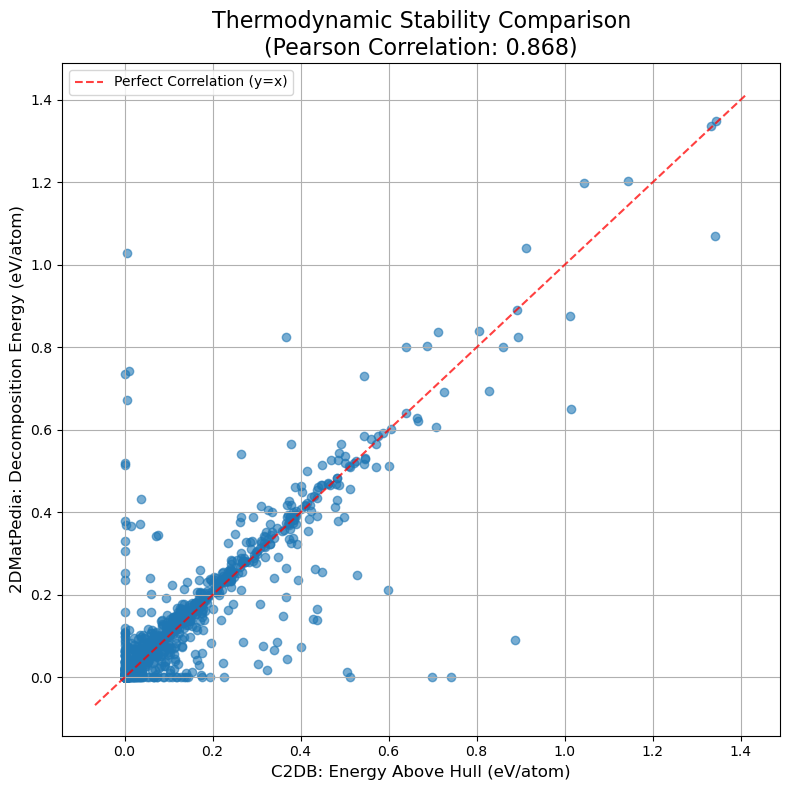

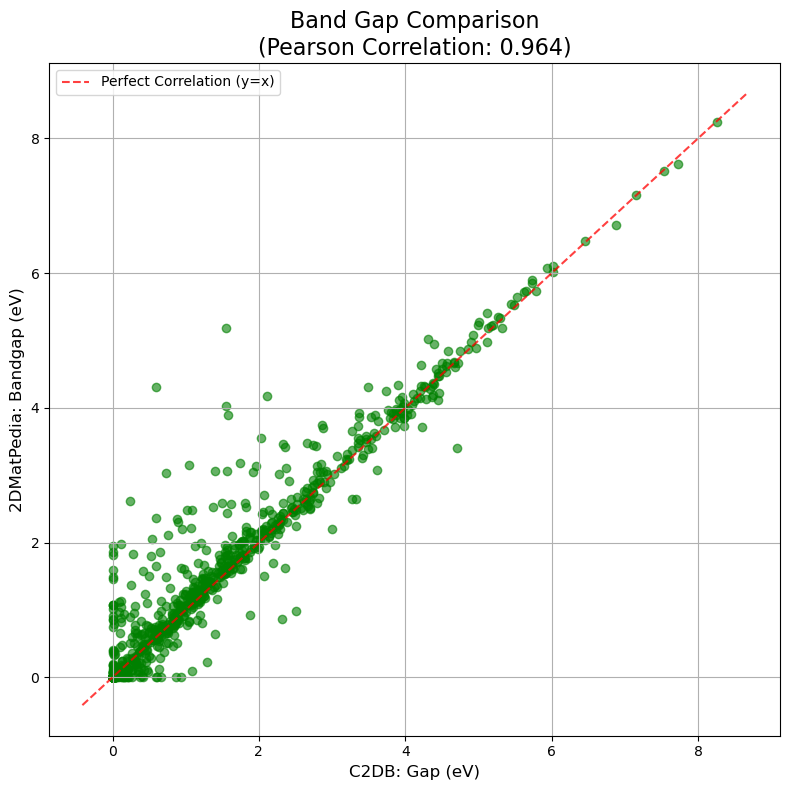

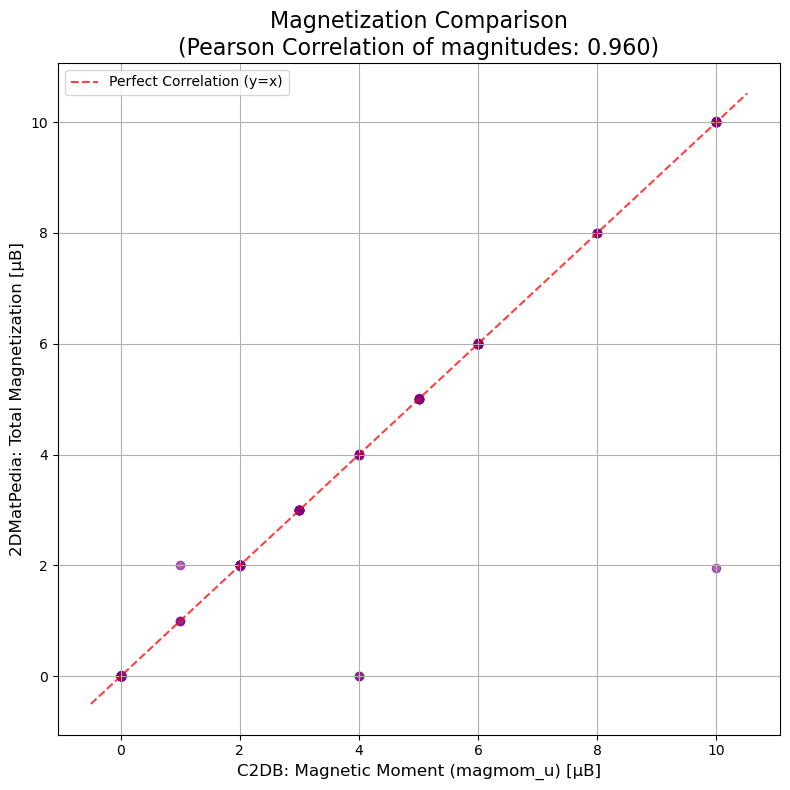

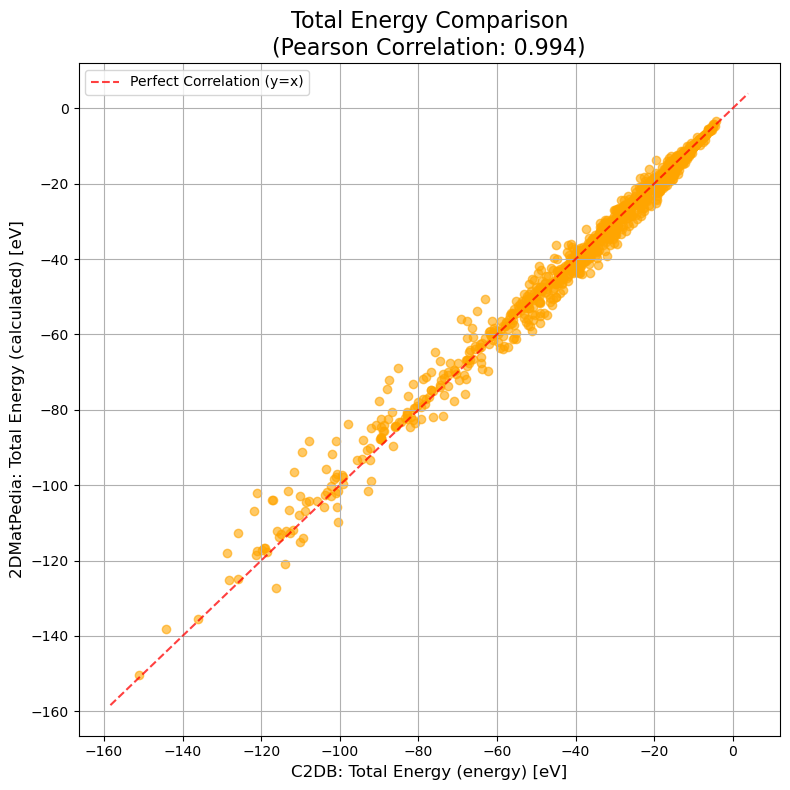

In [20]:
# --- File Configuration ---
COMMON_PROTOS_CSV = "common_formula_symmetry.csv"
OUTPUT_CSV = "properties_comparison.csv"

# --- Property Name Mapping ---
PROPERTY_MAP = {
    'c2db': {
        'stability': 'ehull',
        'gap': 'gap',
        'magnetism': 'magmom_u',
        'energy': 'energy'
    },
    '2dmatpedia': {
        'stability': 'decomposition_energy',
        'gap': 'bandgap',
        'magnetism': 'total_magnetization',
        'energy': 'energy_per_atom'
    }
}

def get_properties_from_db(db_path: str, formula: str, sym_type: str, sym_val: str, prop_map: dict):
    """
    Fetches a specific prototype from a database and returns a dictionary
    with the properties of interest.
    """
    db = connect(db_path)
    
    try:
        row_sample = next(db.select(limit=1))
        keys = list(row_sample.key_value_pairs.keys()) + list(getattr(row_sample, 'data', {}).keys())
    except StopIteration:
        return {}

    num_col = next((c for c in ["sg_number", "number", "lgnum"] if c in keys), None)
    sym_col = next((c for c in ["international", "layergroup"] if c in keys), None)
    
    target_row = None
    # Use the raw formula for searching, as 'formula_norm' may not be in the DB
    candidates = list(db.select(formula=formula))

    for row in candidates:
        try:
            # Note: sym_val is converted to str to ensure consistent comparison
            sym_val_str = str(sym_val)
            if sym_type == 'number' and num_col and str(int(row.get(num_col))) == sym_val_str:
                target_row = row
                break
            elif sym_type == 'symbol' and sym_col:
                db_symb = re.sub(r"\\s+", "", str(row.get(sym_col)).strip()).replace('"', '').replace("'", "")
                if db_symb == sym_val_str:
                    target_row = row
                    break
        except (ValueError, TypeError):
            continue
            
    if target_row:
        properties = {
            'stability': target_row.get(prop_map['stability']),
            'gap': target_row.get(prop_map['gap']),
            'magnetism': target_row.get(prop_map['magnetism']),
            'energy': target_row.get(prop_map['energy']), # ADDED
            'natoms': target_row.natoms # ADDED
        }
        return properties
    return {}

# --- Main Logic ---
if __name__ == "__main__":
    if not os.path.exists(COMMON_PROTOS_CSV):
        print(f"File '{COMMON_PROTOS_CSV}' not found.")
        print("Please run the script that generates the common prototypes list first.")
    else:
        common_df = pd.read_csv(COMMON_PROTOS_CSV)
        comparison_results = []

        print(f"Starting property comparison for {len(common_df)} common prototypes...")

        for index, row in tqdm(common_df.iterrows(), total=len(common_df)):
            # --- MODIFIED LINES HERE ---
            # Using the column names you provided: 'formula', 'symmetry_type', 'symmetry_value'
            formula_val = row['formula']
            sym_type_val = row['symmetry_type']
            sym_value_val = row['symmetry_value']

            props_c2 = get_properties_from_db(C2DB_PATH, formula_val, sym_type_val, sym_value_val, PROPERTY_MAP['c2db'])
            props_m2 = get_properties_from_db(MP2D_PATH, formula_val, sym_type_val, sym_value_val, PROPERTY_MAP['2dmatpedia'])

            if props_c2 and props_m2:
                 comparison_results.append({
                    'formula': formula_val,
                    'sym_val': sym_value_val,
                    'ehull_c2db': props_c2['stability'],
                    'decomp_energy_m2': props_m2['stability'],
                    'gap_c2db': props_c2['gap'],
                    'gap_m2': props_m2['gap'],
                    'magmom_u_c2db': props_c2['magnetism'],
                    'total_magnetization_m2': props_m2['magnetism'],
                    'energy_c2db': props_c2['energy'], # ADDED
                    'energy_per_atom_m2': props_m2['energy'], # ADDED
                    'natoms_m2': props_m2['natoms'] # ADDED
                })

        results_df = pd.DataFrame(comparison_results)
        results_df['total_energy_m2'] = results_df['energy_per_atom_m2'] * results_df['natoms_m2']
        results_df.to_csv(OUTPUT_CSV, index=False)
        print(f"\nComparison results saved to '{OUTPUT_CSV}'.")
        print("\nSample of the compared data:")
        print(results_df.head())

        # --- Data Visualization Section ---
        # (Plotting code remains the same)
        
        # Plot 1: Stability Comparison
        plot_df_stability = results_df.dropna(subset=['ehull_c2db', 'decomp_energy_m2']).copy()
        plot_df_stability['ehull_c2db'] = pd.to_numeric(plot_df_stability['ehull_c2db'])
        plot_df_stability['decomp_energy_m2'] = pd.to_numeric(plot_df_stability['decomp_energy_m2'])
        if not plot_df_stability.empty:
            r_stability, _ = pearsonr(plot_df_stability['ehull_c2db'], plot_df_stability['decomp_energy_m2'])
            plt.figure(figsize=(8, 8))
            plt.scatter(plot_df_stability['ehull_c2db'], plot_df_stability['decomp_energy_m2'], alpha=0.6)
            plt.title(f'Thermodynamic Stability Comparison\n(Pearson Correlation: {r_stability:.3f})', fontsize=16)
            plt.xlabel('C2DB: Energy Above Hull (eV/atom)', fontsize=12)
            plt.ylabel('2DMatPedia: Decomposition Energy (eV/atom)', fontsize=12)
            lims = [min(plt.xlim()[0], plt.ylim()[0]), max(plt.xlim()[1], plt.ylim()[1])]
            plt.plot(lims, lims, 'r--', alpha=0.75, label='Perfect Correlation (y=x)')
            plt.grid(True); plt.legend(); plt.tight_layout()
            plt.savefig('stability_comparison_with_corr.png')
            print("\nChart 'stability_comparison_with_corr.png' generated.")

        # Plot 2: Band Gap Comparison
        plot_df_gap = results_df.dropna(subset=['gap_c2db', 'gap_m2']).copy()
        plot_df_gap['gap_c2db'] = pd.to_numeric(plot_df_gap['gap_c2db'])
        plot_df_gap['gap_m2'] = pd.to_numeric(plot_df_gap['gap_m2'])
        if not plot_df_gap.empty:
            r_gap, _ = pearsonr(plot_df_gap['gap_c2db'], plot_df_gap['gap_m2'])
            plt.figure(figsize=(8, 8))
            plt.scatter(plot_df_gap['gap_c2db'], plot_df_gap['gap_m2'], alpha=0.6, color='green')
            plt.title(f'Band Gap Comparison\n(Pearson Correlation: {r_gap:.3f})', fontsize=16)
            plt.xlabel('C2DB: Gap (eV)', fontsize=12)
            plt.ylabel('2DMatPedia: Bandgap (eV)', fontsize=12)
            lims = [min(plt.xlim()[0], plt.ylim()[0]), max(plt.xlim()[1], plt.ylim()[1])]
            plt.plot(lims, lims, 'r--', alpha=0.75, label='Perfect Correlation (y=x)')
            plt.grid(True); plt.legend(); plt.tight_layout()
            plt.savefig('gap_comparison_with_corr.png')
            print("Chart 'gap_comparison_with_corr.png' generated.")

        # Plot 3: Magnetization Comparison
        plot_df_mag = results_df.dropna(subset=['magmom_u_c2db', 'total_magnetization_m2']).copy()
        plot_df_mag['magmom_u_c2db'] = pd.to_numeric(plot_df_mag['magmom_u_c2db'])
        plot_df_mag['total_magnetization_m2'] = pd.to_numeric(plot_df_mag['total_magnetization_m2'])
        if not plot_df_mag.empty:
            r_mag, _ = pearsonr(np.abs(plot_df_mag['magmom_u_c2db']), np.abs(plot_df_mag['total_magnetization_m2']))
            plt.figure(figsize=(8, 8))
            plt.scatter(plot_df_mag['magmom_u_c2db'], plot_df_mag['total_magnetization_m2'], alpha=0.6, color='purple')
            plt.title(f'Magnetization Comparison\n(Pearson Correlation of magnitudes: {r_mag:.3f})', fontsize=16)
            plt.xlabel('C2DB: Magnetic Moment (magmom_u) [μB]', fontsize=12)
            plt.ylabel('2DMatPedia: Total Magnetization [μB]', fontsize=12)
            lims = [min(plt.xlim()[0], plt.ylim()[0]), max(plt.xlim()[1], plt.ylim()[1])]
            plt.plot(lims, lims, 'r--', alpha=0.75, label='Perfect Correlation (y=x)')
            plt.grid(True); plt.legend(); plt.tight_layout()
            plt.savefig('magnetization_comparison_with_corr.png')
            print("Chart 'magnetization_comparison_with_corr.png' generated.")

        # Plot 4: Total Energy Comparison
        plot_df_energy = results_df.dropna(subset=['energy_c2db', 'total_energy_m2']).copy()
        plot_df_energy['energy_c2db'] = pd.to_numeric(plot_df_energy['energy_c2db'])
        # The 'total_energy_m2' is already numeric from the calculation
        
        if not plot_df_energy.empty:
            r_energy, _ = pearsonr(plot_df_energy['energy_c2db'], plot_df_energy['total_energy_m2'])
            plt.figure(figsize=(8, 8))
            plt.scatter(plot_df_energy['energy_c2db'], plot_df_energy['total_energy_m2'], alpha=0.6, color='orange')
            plt.title(f'Total Energy Comparison\n(Pearson Correlation: {r_energy:.3f})', fontsize=16)
            plt.xlabel('C2DB: Total Energy (energy) [eV]', fontsize=12)
            plt.ylabel('2DMatPedia: Total Energy (calculated) [eV]', fontsize=12)
            lims = [min(plt.xlim()[0], plt.ylim()[0]), max(plt.xlim()[1], plt.ylim()[1])]
            plt.plot(lims, lims, 'r--', alpha=0.75, label='Perfect Correlation (y=x)')
            plt.grid(True); plt.legend(); plt.tight_layout()
            plt.savefig('total_energy_comparison_with_corr.png')
            print("\nChart 'total_energy_comparison_with_corr.png' generated.")

In [22]:
# --- Main Logic ---
if __name__ == "__main__":
    if not os.path.exists(COMMON_PROTOS_CSV):
        print(f"File '{COMMON_PROTOS_CSV}' not found.")
        print("Please run the script that generates the common prototypes list first.")
    else:
        common_df = pd.read_csv(COMMON_PROTOS_CSV)
        comparison_results = []

        print(f"Starting property comparison for {len(common_df)} common prototypes...")

        for index, row in tqdm(common_df.iterrows(), total=len(common_df)):
            formula_val, sym_type_val, sym_value_val = row['formula'], row['symmetry_type'], row['symmetry_value']

            props_c2 = get_properties_from_db(C2DB_PATH, formula_val, sym_type_val, sym_value_val, PROPERTY_MAP['c2db'])
            props_m2 = get_properties_from_db(MP2D_PATH, formula_val, sym_type_val, sym_value_val, PROPERTY_MAP['2dmatpedia'])

            if props_c2 and props_m2:
                comparison_results.append({
                    'formula': formula_val,
                    'sym_val': sym_value_val,
                    'ehull_c2db': props_c2['stability'],
                    'decomp_energy_m2': props_m2['stability'],
                    'gap_c2db': props_c2['gap'],
                    'gap_m2': props_m2['gap'],
                    'magmom_u_c2db': props_c2['magnetism'],
                    'total_magnetization_m2': props_m2['magnetism'],
                    'energy_c2db': props_c2['energy'],
                    'energy_per_atom_m2': props_m2['energy'],
                    'natoms_m2': props_m2['natoms']
                })

        results_df = pd.DataFrame(comparison_results)
        results_df['total_energy_m2'] = results_df['energy_per_atom_m2'] * results_df['natoms_m2']

        print("\n--- Summary of Comparable Data Points ---")

        # --- Stability Count ---
        plot_df_stability = results_df.dropna(subset=['ehull_c2db', 'decomp_energy_m2'])
        print(f"Found {len(plot_df_stability)} common structures with valid Stability data.")

        # --- Band Gap Count ---
        plot_df_gap = results_df.dropna(subset=['gap_c2db', 'gap_m2'])
        print(f"Found {len(plot_df_gap)} common structures with valid Band Gap data.")
        
        # --- Magnetization Count ---
        plot_df_mag = results_df.dropna(subset=['magmom_u_c2db', 'total_magnetization_m2'])
        print(f"Found {len(plot_df_mag)} common structures with valid Magnetization data.")

        # --- Total Energy Count ---
        plot_df_energy = results_df.dropna(subset=['energy_c2db', 'total_energy_m2'])
        print(f"Found {len(plot_df_energy)} common structures with valid Total Energy data.")

Starting property comparison for 21443 common prototypes...


  0%|          | 0/21443 [00:00<?, ?it/s]

100%|██████████| 21443/21443 [01:30<00:00, 236.75it/s]


--- Summary of Comparable Data Points ---
Found 1215 common structures with valid Stability data.
Found 1081 common structures with valid Band Gap data.
Found 117 common structures with valid Magnetization data.
Found 1215 common structures with valid Total Energy data.


In [ ]:
def get_prototypes_and_data_map(db_path: str):
    """
    Reads an ASE database and returns a dictionary mapping each unique prototype
    (formula, sym_type, sym_val) to its first corresponding row object.
    """
    if not os.path.exists(db_path):
        print(f"WARNING: Database file not found: {db_path}")
        return {}

    proto_to_row_map = {}
    db = connect(db_path)
    
    try:
        row_sample = next(db.select(limit=1))
        keys = list(row_sample.key_value_pairs.keys()) + list(getattr(row_sample, 'data', {}).keys())
    except StopIteration:
        return {}

    num_col = next((c for c in ["sg_number", "number", "lgnum"] if c in keys), None)
    sym_col = next((c for c in ["international", "layergroup"] if c in keys), None)

    for row in db.select():
        formula = row.get("formula_norm", row.formula)
        prototype = None
        
        if num_col and row.get(num_col) is not None:
            try:
                prototype = (formula, "number", str(int(row.get(num_col))))
            except (ValueError, TypeError): pass
        elif sym_col and row.get(sym_col) is not None:
            try:
                sym_symb = re.sub(r"\\s+", "", str(row.get(sym_col)).strip()).replace('"', '').replace("'", "")
                if sym_symb:
                    prototype = (formula, "symbol", sym_symb)
            except (ValueError, TypeError): pass

        if prototype and prototype not in proto_to_row_map:
            proto_to_row_map[prototype] = row
            
    return proto_to_row_map

# --- Main Analysis Logic ---
if __name__ == "__main__":
    
    # --- Part 1: C2DB Analysis ---
    print(f"Analyzing {C2DB_PATH}...")
    c2db_map = get_prototypes_and_data_map(C2DB_PATH)
    
    c2db_protos_gap = set()
    c2db_protos_gap_ehull = set()
    c2db_protos_gap_energy = set()
    c2db_protos_all_three = set()
    
    for proto, row in tqdm(c2db_map.items(), desc="Checking C2DB"):
        kvp = row.key_value_pairs
        
        has_gap = kvp.get('gap') is not None
        has_ehull = kvp.get('ehull') is not None
        has_energy = kvp.get('energy') is not None

        if has_gap: c2db_protos_gap.add(proto)
        if has_gap and has_ehull: c2db_protos_gap_ehull.add(proto)
        if has_gap and has_energy: c2db_protos_gap_energy.add(proto)
        if has_gap and has_ehull and has_energy: c2db_protos_all_three.add(proto)
            
    print("\n--- C2DB Data Completeness ---")
    print(f"Unique structures with non-null 'gap': {len(c2db_protos_gap)}")
    print(f"Unique structures with non-null 'gap' AND 'ehull': {len(c2db_protos_gap_ehull)}")
    print(f"Unique structures with non-null 'gap' AND 'energy': {len(c2db_protos_gap_energy)}")
    print(f"Unique structures with all three ('gap', 'ehull', 'energy'): {len(c2db_protos_all_three)}")
    
    # --- Part 2: 2DMatPedia Analysis ---
    print(f"\nAnalyzing {MP2D_PATH}...")
    mp2d_map = get_prototypes_and_data_map(MP2D_PATH)

    mp2d_protos_gap = set()
    mp2d_protos_gap_stability = set()
    mp2d_protos_gap_energy = set()
    mp2d_protos_all_three = set()

    for proto, row in tqdm(mp2d_map.items(), desc="Checking 2DMatPedia"):
        kvp = row.key_value_pairs

        has_bandgap = kvp.get('bandgap') is not None
        has_stability = kvp.get('decomposition_energy') is not None
        has_energy = kvp.get('energy_per_atom') is not None

        if has_bandgap: mp2d_protos_gap.add(proto)
        if has_bandgap and has_stability: mp2d_protos_gap_stability.add(proto)
        if has_bandgap and has_energy: mp2d_protos_gap_energy.add(proto)
        if has_bandgap and has_stability and has_energy: mp2d_protos_all_three.add(proto)
            
    print("\n--- 2DMatPedia Data Completeness ---")
    print(f"Unique structures with non-null 'bandgap': {len(mp2d_protos_gap)}")
    print(f"Unique structures with non-null 'bandgap' AND 'decomposition_energy': {len(mp2d_protos_gap_stability)}")
    print(f"Unique structures with non-null 'bandgap' AND 'energy_per_atom': {len(mp2d_protos_gap_energy)}")
    print(f"Unique structures with all three: {len(mp2d_protos_all_three)}")

    # --- Part 3: Combined Analysis (MODIFIED with Intersection) ---
    # Union -> Total unique prototypes that meet criteria in at least ONE DB
    total_unique_gap = c2db_protos_gap.union(mp2d_protos_gap)
    total_unique_gap_stability = c2db_protos_gap_ehull.union(mp2d_protos_gap_stability)
    total_unique_gap_energy = c2db_protos_gap_energy.union(mp2d_protos_gap_energy)
    total_unique_all_three = c2db_protos_all_three.union(mp2d_protos_all_three)
    
    # ADDED: Intersection -> Prototypes that meet criteria in BOTH DBs
    common_gap = c2db_protos_gap.intersection(mp2d_protos_gap)
    common_gap_stability = c2db_protos_gap_ehull.intersection(mp2d_protos_gap_stability)
    common_gap_energy = c2db_protos_gap_energy.intersection(mp2d_protos_gap_energy)
    common_all_three = c2db_protos_all_three.intersection(mp2d_protos_all_three)
    
    print("\n" + "="*70)
    print("[OVERALL RESULTS - Summary of Unique Combined Structures]")
    print("-" * 70)
    print(f"{'Criteria':<35} | {'Total Unique (Union)':<25} | {'In Common (Intersection)':<25}")
    print("-" * 70)
    print(f"{'With Gap':<35} | {len(total_unique_gap):<25} | {len(common_gap):<25}")
    print(f"{'With Gap + Stability':<35} | {len(total_unique_gap_stability):<25} | {len(common_gap_stability):<25}")
    print(f"{'With Gap + Energy':<35} | {len(total_unique_gap_energy):<25} | {len(common_gap_energy):<25}")
    print(f"{'With ALL THREE Properties':<35} | {len(total_unique_all_three):<25} | {len(common_all_three):<25}")
    print("="*70)

Analyzing c2db.db...


Checking C2DB: 100%|██████████| 16504/16504 [00:00<00:00, 248097.92it/s]



--- C2DB Data Completeness ---
Unique structures with non-null 'gap': 8414
Unique structures with non-null 'gap' AND 'ehull': 8414
Unique structures with non-null 'gap' AND 'energy': 0
Unique structures with all three ('gap', 'ehull', 'energy'): 0

Analyzing 2dmatpedia_final.db...


Checking 2DMatPedia: 100%|██████████| 6159/6159 [00:00<00:00, 226658.46it/s]


--- 2DMatPedia Data Completeness ---
Unique structures with non-null 'bandgap': 6159
Unique structures with non-null 'bandgap' AND 'decomposition_energy': 5970
Unique structures with non-null 'bandgap' AND 'energy_per_atom': 5971
Unique structures with all three: 5970

[OVERALL RESULTS - Summary of Unique Combined Structures]
----------------------------------------------------------------------
Criteria                            | Total Unique (Union)      | In Common (Intersection) 
----------------------------------------------------------------------
With Gap                            | 13492                     | 1081                     
With Gap + Stability                | 13307                     | 1077                     
With Gap + Energy                   | 5971                      | 0                        
With ALL THREE Properties           | 5970                      | 0                        
